In [1]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import torch
from torch.nn import DataParallel
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader
from shapely.geometry import box
from torchvision import transforms
import time
import random
import torchvision.models as models


from pytorch_segmentation.data.rwanda_dataset import RwandaDataset
from pytorch_segmentation.data.inmemory_dataset import InMemorySatDataset
from pytorch_segmentation.train_net import train_classification
from pytorch_segmentation.models import UNet
from pytorch_segmentation.losses.dice import DiceLoss
from pytorch_segmentation.losses.tversky import TverskyLoss
import pytorch_segmentation.augmentation.transforms as seg_transforms

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [2]:

#SA data
data_path = "/home/jovyan/work/satellite_data/tmp/2018.vrt"
label_path_sa_train = "data/datasets/V9/train/SA"
label_path_sa_val = "data/datasets/V9/val/SA"
label_path_sa_test = "data/datasets/V9/test/SA"

#Rwanda data
shape_path_rw = "data/datasets/V1/rwanda_tree_shapes/training_data_polygons_model_29_v2.shp"
train_data_path_rw = "data/datasets/V9/train/rwanda"
val_data_path_rw = "data/datasets/V9/val/rwanda"
test_data_path_rw = "data/datasets/V9/test/rwanda"


tensorboard_path = "/home/jovyan/work/notebooks/runs"

# patch_size = [364,364,3]# [x,y,bands]
# overlap = 300

# patch_size = [321,321,3]# [x,y,bands]
# overlap = 270


patch_size = [300,300]# [x,y,bands]
overlap = 260

val_patch_size = [256,256]# [x,y,bands]
val_overlap = 200

test_patch_size = [256,256]
overlap_test = 128

padding = False#True

epochs = 500#25

early_stopping = None

dropout = True

scheduler_warmup= 20#10
sched_step = 15
sched_gamma = 0.1

#batch_size = 200
#batch_size = 50
batch_size = 100 #150 #75

lr = 1e-3
weight_decay = 1e-3

weighted = True
weight = 0.3

metric = "iou"

n_channels = 3

nworkers = 4
pin_memory = True

nimgs = 4

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

save_dir = "saved_models"


# transform = seg_transforms.Compose([
#     seg_transforms.CLAHE_Norm(),
#     seg_transforms.RandomRotation(17),
#     seg_transforms.RandomHorizontalFlip(0.5),
#     seg_transforms.RandomVerticalFlip(0.5),
#     seg_transforms.CenterCrop(256),
#     seg_transforms.Add_VDVI(),
#     seg_transforms.ColorJitter(brightness=(0.9,1.35),contrast=0.5,saturation=0.2),
#     # seg_transforms.ColorJitter(brightness=(0.9,1.15),contrast=0.2,saturation=0.1),
#      seg_transforms.RandomPixel(ratio=0.005,random_apply=0.5),
# ])

# #for 300,300 images
# transform = seg_transforms.Compose([
#     #seg_transforms.CLAHE_Norm(),
#     seg_transforms.Pad(100),
#     seg_transforms.RandomRotation(360),
#     seg_transforms.CenterCrop(282),
#     seg_transforms.RandomResizeCrop((256,256),(0.125,1)),
#     #seg_transforms.Add_VDVI(),
#     seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.4),saturation=0.2),
#     #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
#      seg_transforms.RandomPixel(ratio=0.005,random_apply=0.5),
# ])

mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

transform = seg_transforms.Compose([
    #seg_transforms.CLAHE_Norm(),
    seg_transforms.RandomApply([
        seg_transforms.Pad(100),
        seg_transforms.RandomRotation(360),
        seg_transforms.CenterCrop(282),
        seg_transforms.RandomResizeCrop((256,256),scale=(0.125,1)),
        #seg_transforms.Add_VDVI(),
        seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.4),saturation=0.2),
        #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
        seg_transforms.RandomPixel(ratio=0.005,random_apply=0.2)]
    ,p=0.8),
    seg_transforms.CenterCrop(256),
    seg_transforms.Normalize(mean, std)
])

# #for 300,300 images
# transform = seg_transforms.Compose([
#     #seg_transforms.CLAHE_Norm(),
#     seg_transforms.Pad(100),
#     seg_transforms.RandomRotation(360),
#     seg_transforms.CenterCrop(282),
#     seg_transforms.RandomResizeCrop((256,256),(0.5,1)),
#     #seg_transforms.Add_VDVI(),
#     seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.9,1.4),saturation=0.2),
#     #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
#      seg_transforms.RandomPixel(ratio=0.005,random_apply=0.5),
# ])


### For 321,321 patches with 270 overlap
# transform = seg_transforms.Compose([
#     #seg_transforms.CLAHE_Norm(),
#     seg_transforms.Pad(79),
#     seg_transforms.RandomRotation(360),
#     seg_transforms.CenterCrop(282),
#     seg_transforms.RandomCrop(256),
#     #seg_transforms.Add_VDVI(),
#     seg_transforms.ColorJitter(brightness=(0.9,1.3),contrast=(0.8,1.4),saturation=0.2),
#     #seg_transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
#      seg_transforms.RandomPixel(ratio=0.005,random_apply=0.5),
# ])


val_transform = seg_transforms.Compose([
    seg_transforms.Normalize(mean, std)
    #seg_transforms.CLAHE_Norm(),
    # seg_transforms.RandomHorizontalFlip(0.5),
    # seg_transforms.RandomVerticalFlip(0.5),
    #seg_transforms.UnmaskEdges([225,225])
#         seg_transforms.Normalize(mean=[0.5492, 0.5190, 0.4393],
#                                          std=[0.1381, 0.1320, 0.1349])
])

test_transform = None


# 1.1 Data Collection

#### Create Training and Test Dataset - SA

In [4]:
train_dataset_sa = InMemorySatDataset(data_file_path=data_path,mask_path=label_path_sa_train,
                             overlap=overlap,patch_size=patch_size,padding=padding,transform=transform,mode="classification")
val_dataset_sa = InMemorySatDataset(data_file_path=data_path,mask_path=label_path_sa_val,
                             overlap=val_overlap,patch_size=val_patch_size,padding=padding,transform=val_transform,mode="classification")
# test_dataset_sa = InMemorySatDataset(data_file_path=data_path,mask_path=label_path_sa_test,
#                              overlap=overlap_test,patch_size=test_patch_size,padding=padding,transform=test_transform)


print("Len Train: ",len(train_dataset_sa))
print("Len Val: ",len(val_dataset_sa))
#print("Len Test: ",len(test_dataset_sa))

Len Train:  50807
Len Val:  9880


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


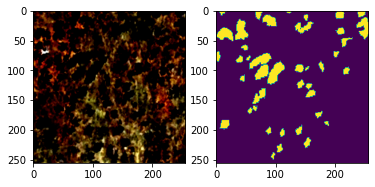

In [5]:
train_dataset_sa.show_tuple(31500)

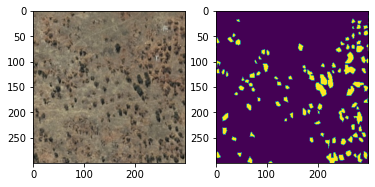

In [6]:
train_dataset_sa.show_tuple(31500,transform=False)

#### Create Training and Test Dataset - Rwanda

In [7]:
train_dataset_rw = RwandaDataset(dataset_path=None,data_file_path=train_data_path_rw,
                   shape_path=shape_path_rw,
                             overlap=overlap,patch_size=patch_size,padding=padding,transform=transform,mode="classification")
val_dataset_rw = RwandaDataset(dataset_path=None,data_file_path=val_data_path_rw,
                   shape_path=shape_path_rw,
                             overlap=val_overlap,patch_size=val_patch_size,padding=padding,transform=val_transform,mode="classification")
# test_dataset_rw = RwandaDataset(dataset_path=None,data_file_path=test_data_path_rw,
#                    shape_path=shape_path_rw, overlap=overlap_test,patch_size=test_patch_size,padding=padding,transform=test_transform)

print("Len Train: ",len(train_dataset_rw))
print("Len Val: ",len(val_dataset_rw))
#print("Len Test: ",len(test_dataset_rw))

100%|██████████| 36/36 [00:16<00:00,  2.12it/s]


Len Train:  51574
Len Val:  9593


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


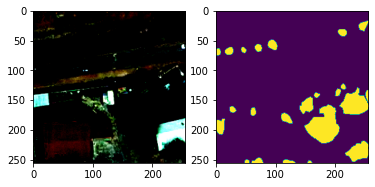

In [8]:
train_dataset_rw.show_tuple(500)

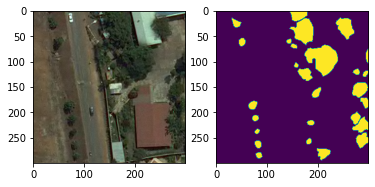

In [9]:
train_dataset_rw.show_tuple(500,transform=False)

# 2. Model Training


In [10]:
from pytorch_segmentation.utils.sampling import create_weighted_dataset
#train_dataset,weights = create_weighted_dataset([train_dataset_sa],weight=weight)

train_dataset,weights = create_weighted_dataset([train_dataset_sa,train_dataset_rw],weight=weight)

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights),replacement=True) 

#val_dataset = torch.utils.data.ConcatDataset([val_dataset_sa])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_sa,val_dataset_rw])
#test_dataset = torch.utils.data.ConcatDataset([test_dataset_rw, test_dataset_sa])

In [11]:
if weighted:
    train_dl =DataLoader(train_dataset,sampler=sampler,batch_size=batch_size,num_workers=nworkers,shuffle=False,pin_memory=pin_memory,
                      drop_last=True)
else:
    train_dl =DataLoader(train_dataset,batch_size=batch_size,num_workers=nworkers,shuffle=True,pin_memory=pin_memory,
                  drop_last=True)

if (len(val_dataset) % batch_size) < nimgs:
    val_dl = DataLoader(val_dataset,batch_size=batch_size,num_workers=nworkers,
                     shuffle=True,pin_memory=pin_memory,drop_last=True)
else:
    val_dl = DataLoader(val_dataset,batch_size=batch_size,num_workers=nworkers,
                         shuffle=True,pin_memory=pin_memory,drop_last=False)
# test_dl = DataLoader(test_dataset,batch_size=batch_size,num_workers=nworkers,
#                      shuffle=False,pin_memory=pin_memory,drop_last=False)

## 2.2 Resnet50
- train binary classifier to decide whether patch is empty or not
- labels need to be just 0/1
- new training function

In [12]:
model_path = save_dir+"/resnet101"+str(time.strftime("%d_%m_%Y_%H%M%S"))
# Change here to adapt to your data
net = models.resnet101(pretrained=True)

fc = nn.Sequential(nn.Linear(2048,1024),nn.ReLU(inplace=True),
                   nn.Linear(1024,512),nn.ReLU(inplace=True),
                   nn.Linear(512,128),nn.ReLU(inplace=True),nn.Linear(128,1))
#fc = nn.Linear(2048,46)
net.fc = fc

net = net.to(device=device)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
#criterion = nn.CrossEntropyLoss(weight=normedWeights)
criterion = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(opt, sched_step,gamma=sched_gamma) #ReduceLROnPlateau(opt, 'max', patience=2) #S
#scheduler = None

In [ ]:
net = train_classification(net,train_dl,val_dl,criterion,opt,
                                             num_epochs=epochs,model_path=model_path+".pth",scheduler=scheduler,
                                              tensorboard_path=tensorboard_path,device=device,seed=seed)

Epoch 0/499
----------
train Loss: 0.1597 Acc: 0.9452 F1:0.9453
val Loss: 0.1004 Acc: 0.9720 F1:0.9718

Epoch 1/499
----------
train Loss: 0.1336 Acc: 0.9532 F1:0.9537
val Loss: 0.0983 Acc: 0.9747 F1:0.9747

Epoch 2/499
----------
train Loss: 0.1224 Acc: 0.9559 F1:0.9564
val Loss: 0.0678 Acc: 0.9788 F1:0.9788

Epoch 3/499
----------
train Loss: 0.1156 Acc: 0.9583 F1:0.9589
val Loss: 0.0721 Acc: 0.9776 F1:0.9776
0.9788084196960118

Epoch 4/499
----------
train Loss: 0.1123 Acc: 0.9590 F1:0.9595
val Loss: 0.0919 Acc: 0.9780 F1:0.9780
0.9788084196960118

Epoch 5/499
----------
train Loss: 0.1079 Acc: 0.9603 F1:0.9609
val Loss: 0.0603 Acc: 0.9742 F1:0.9742
0.9788084196960118

Epoch 7/499
----------
train Loss: 0.1053 Acc: 0.9610 F1:0.9617
val Loss: 0.0756 Acc: 0.9759 F1:0.9758
0.9788084196960118

Epoch 8/499
----------
train Loss: 0.1039 Acc: 0.9621 F1:0.9627
val Loss: 0.0593 Acc: 0.9798 F1:0.9798

Epoch 9/499
----------
train Loss: 0.1023 Acc: 0.9624 F1:0.9630
val Loss: 0.0697 Acc: 0.9754